In [1]:
import numpy as np
import scipy
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.rcParams['pdf.fonttype'] = 42

import torch
import torchvision
from torch import nn, optim
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.io import loadmat
import os, sys
import torchvision.transforms as transforms
import string
from  collections import defaultdict
from sklearn.linear_model import LassoCV

# images = loadmat('baoimg.mat').get('img')
%run clean_cornets.py

In [2]:
from torchvision import datasets, transforms

data_dir = 'stimuli/classification_dataset/'
transform = {'train': transforms.Compose([transforms.Resize((224,224)),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),}

chosen_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform =  transform[x]) for x in ['train']}
dataloaders = {x: torch.utils.data.DataLoader(chosen_datasets[x], batch_size = 80,shuffle = False) for x in ['train']}

wordlist = chosen_datasets['train'].classes


In [3]:
dataiter = iter(dataloaders['train'])

nBli = {}; 
nBli['v1'] = []; nBli['v2'] = []; nBli['v4'] = []; nBli['it'] = []; nBli['h'] = []; nBli['out'] = []

# net = CORNet_Z_nonbiased_words()
# checkpoint = torch.load('models/save_lit_no_bias_z_79_full_nomir.pth.tar')['state_dict']

net = CORNet_Z_biased_words()
checkpoint = torch.load('models/save_lit_bias_z_79_full_nomir.pth.tar')['state_dict']
# net = CORnet_Z_tweak()
# checkpoint = torch.load('models/save_illit_z_79_full_nomir.pth.tar')['state_dict']

for key in list(checkpoint.keys()):
    if 'module.' in key:
        checkpoint[key.replace('module.', '')] = checkpoint[key]
        del checkpoint[key]
net.load_state_dict(checkpoint)
# net.eval() 
    
for i in range(28):
    stimtemp, classes = next(dataiter)
    varV1,varV2,varV4,varIt,varh, varOut = net(stimtemp.float())
    nBli['v1'].extend(varV1.detach().numpy())
    nBli['v2'].extend(varV2.detach().numpy())
    nBli['v4'].extend(varV4.detach().numpy())
    nBli['it'].extend(varIt.detach().numpy())
    nBli['h'].extend(varh.detach().numpy())
    nBli['out'].extend(varOut.detach().numpy())
    print(i)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


In [4]:
train_id = np.arange(0,248*5,5)
# test_id_font = np.arange(1,248*5,5)
# test_id_size = np.arange(2,248*5,5)
# test_id_pos  = np.arange(3,248*5,5)
# test_id_case = np.arange(4,248*5,5)
# test_id_Mtr = np.arange(248*5,248*6)
# test_id_Etr = np.arange(248*6,248*7)
# test_id_Msb = np.arange(248*7,248*8)
# test_id_Esb = np.arange(248*8,248*9)

test_id = ['']*8
test_id[0] = np.arange(1,248*5,5)
test_id[1] = np.arange(2,248*5,5)
test_id[2]  = np.arange(3,248*5,5)
test_id[3] = np.arange(4,248*5,5)
test_id[4] = np.arange(248*5,248*6)
test_id[5] = np.arange(248*6,248*7)
test_id[6] = np.arange(248*7,248*8)
test_id[7] = np.arange(248*8,248*9)

In [5]:
from sklearn.decomposition import PCA
pcax = PCA(n_components=30)

ltype = ['v1','v2','v4','it','h','out']

test_acc = np.zeros((len(ltype),8))
train_acc = np.zeros((len(ltype)))
for i,layer in enumerate(ltype):
    tr_pattern = np.array(nBli[layer])[train_id,:]
    pcax.fit(tr_pattern)
    pc_tr = pcax.transform(tr_pattern)
    
    pc_tr = np.c_[pc_tr, np.ones((np.shape(pc_tr)[0],1))]
    tr_label = np.identity(248)
    weights = (tr_label@np.linalg.pinv(pc_tr).T).T

    tr_pred = pc_tr@weights
    train_acc[i] = np.mean(np.argmax(tr_pred,1) == range(248))

    for t in range(8):
        ts_pattern = np.array(nBli[layer])[test_id[t],:]
        pc_ts = pcax.transform(ts_pattern)
        pc_ts = np.c_[pc_ts , np.ones((np.shape(pc_ts)[0],1))]
        test_pred = pc_ts@weights
        test_acc[i,t] = np.mean(np.argmax(test_pred,1) == range(248))

    

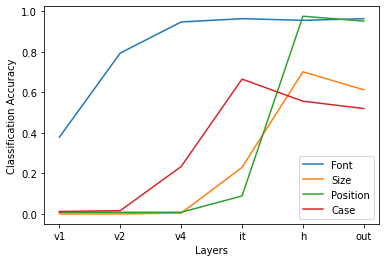

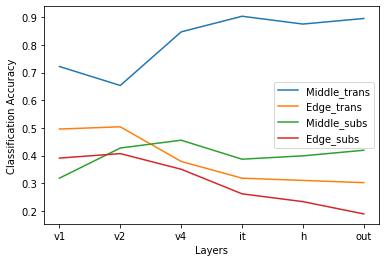

In [6]:
plt.plot(test_acc[:,:4]);
plt.xticks(range(6), labels = ltype);
plt.xlabel('Layers')
plt.ylabel('Classification Accuracy');
plt.legend(['Font','Size','Position','Case'])

plt.figure(2)
plt.plot(test_acc[:,4:]);
plt.xticks(range(6), labels = ltype);
plt.xlabel('Layers')
plt.ylabel('Classification Accuracy');
plt.legend(['Middle_trans','Edge_trans','Middle_subs','Edge_subs'])
